In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# Creating multiple dataframe with different "look back" periods
# The periods are 1 day, 3 days. 7 days. 15 days. 30 days and 60 days
# The look back periods should be in the form of a list
# For example, if the look back period is 3, then the dataframe should have 3 columns
# Date, Close, [Close(t-1), Close(t-2), Close(t-3)]

def create_look_back_arrays(df, window_size = 1):
    df = df.drop(columns = ['Date'])
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i+window_size])
        Y.append(df_as_np[i+window_size])
    return np.array(X), np.array(Y)

In [3]:
df = pd.read_csv('../Data/ethereum_data.csv')

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
2809,2022-05-27,29251.140625,29346.943359,28326.613281,28627.574219,28627.574219,36582005748
2810,2022-05-28,28622.625000,28814.900391,28554.566406,28814.900391,28814.900391,35519577634
2811,2022-05-29,29019.867188,29498.009766,28841.107422,29445.957031,29445.957031,18093886409
2812,2022-05-30,29443.365234,31949.630859,29303.572266,31726.390625,31726.390625,39277993274


In [5]:
df = df[['Date', 'Close']]

In [6]:
df

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
2809,2022-05-27,28627.574219
2810,2022-05-28,28814.900391
2811,2022-05-29,29445.957031
2812,2022-05-30,31726.390625


In [7]:
# Scale the values in the Close column
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

/var/folders/76/w363ly_90ln6pf3txlrc64bw0000gn/T/ipykernel_57294/3875126601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


In [8]:
df

,Date,Close
0,2014-09-17,0.004144
1,2014-09-18,0.003655
2,2014-09-19,0.003216
3,2014-09-20,0.003425
4,2014-09-21,0.003275
...,...,...
2809,2022-05-27,0.422170
2810,2022-05-28,0.424949
2811,2022-05-29,0.434314
2812,2022-05-30,0.468154


In [9]:
x_1, y_1 = create_look_back_arrays(df, 1)
x_3, y_3 = create_look_back_arrays(df, 3)
x_7, y_7 = create_look_back_arrays(df, 7)
x_15, y_15 = create_look_back_arrays(df, 15)
x_30, y_30 = create_look_back_arrays(df, 30)
x_60, y_60 = create_look_back_arrays(df, 60)

# 1 Day look back window

In [10]:
x_1.shape, y_1.shape

((2813, 1, 1), (2813, 1))

In [11]:
X_1_train, y_1_train = x_1[:int(0.8*len(x_1))], y_1[:int(0.8*len(x_1))]
X_1_val, y_1_val = x_1[int(0.8*len(x_1)):int(0.9*len(x_1))], y_1[int(0.8*len(x_1)):int(0.9*len(x_1))]
X_1_test, y_1_test = x_1[int(0.9*len(x_1)):], y_1[int(0.9*len(x_1)):]
X_1_train.shape, y_1_train.shape, X_1_val.shape, y_1_val.shape, X_1_test.shape, y_1_test.shape

((2250, 1, 1), (2250, 1), (281, 1, 1), (281, 1), (282, 1, 1), (282, 1))

In [12]:
model_1 = Sequential()
model_1.add(InputLayer(input_shape = (1, 1)))
model_1.add(GRU(64))
model_1.add(Dense(8, activation = 'relu'))
model_1.add(Dense(1, activation = 'linear'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
cp = ModelCheckpoint('models/gru_1.h5', save_best_only = True)
model_1.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [14]:
model_1.fit(X_1_train, y_1_train, epochs = 200, validation_data = (X_1_val, y_1_val), callbacks = [cp])

Epoch 1/200
71/71 [==============================] - 1s 4ms/step - loss: 0.0052 - root_mean_squared_error: 0.0722 - mean_absolute_error: 0.0529 - val_loss: 0.2862 - val_root_mean_squared_error: 0.5350 - val_mean_absolute_error: 0.5063
Epoch 2/200
71/71 [==============================] - 0s 1ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - mean_absolute_error: 0.0443 - val_loss: 0.2436 - val_root_mean_squared_error: 0.4935 - val_mean_absolute_error: 0.4646
Epoch 3/200
54/71 [=====================>........] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0478 - mean_absolute_error: 0.0410

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 0s 1ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462 - mean_absolute_error: 0.0399 - val_loss: 0.2186 - val_root_mean_squared_error: 0.4675 - val_mean_absolute_error: 0.4388
Epoch 4/200
71/71 [==============================] - 0s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - mean_absolute_error: 0.0361 - val_loss: 0.1993 - val_root_mean_squared_error: 0.4464 - val_mean_absolute_error: 0.4181
Epoch 5/200
71/71 [==============================] - 0s 1ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0320 - val_loss: 0.1811 - val_root_mean_squared_error: 0.4256 - val_mean_absolute_error: 0.3977
Epoch 6/200
71/71 [==============================] - 0s 1ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - mean_absolute_error: 0.0277 - val_loss: 0.1635 - val_root_mean_squared_error: 0.4043 - val_mean_absolute_error: 0.3769
Epoch 7/200
71/71 [==============================] - 0s 1ms/step - loss:

In [15]:
model_1 = load_model('models/gru_1.h5')

In [16]:
test_1_predictions = model_1.predict(X_1_test)
test_results = pd.DataFrame({'Actual': y_1_test.flatten(), 'Predicted': test_1_predictions.flatten()})
test_results

9/9 [==============================] - 0s 632us/step


,Actual,Predicted
0,0.732586,0.471150
1,0.705281,0.472623
2,0.723900,0.460555
3,0.693946,0.468783
4,0.725352,0.455549
...,...,...
277,0.422170,0.339485
278,0.424949,0.335284
279,0.434314,0.336514
280,0.468154,0.340659


In [17]:
# Creating a dataframe with the actual and predicted values without the scaling 
test_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_1_test).flatten(), 'Predicted': scaler.inverse_transform(test_1_predictions).flatten()})
test_results_unscaled

,Actual,Predicted
0,49546.148438,31928.289062
1,47706.117188,32027.552734
2,48960.789062,31214.343750
3,46942.218750,31768.761719
4,49058.667969,30876.990234
...,...,...
277,28627.574219,23055.556641
278,28814.900391,22772.441406
279,29445.957031,22855.339844
280,31726.390625,23134.689453


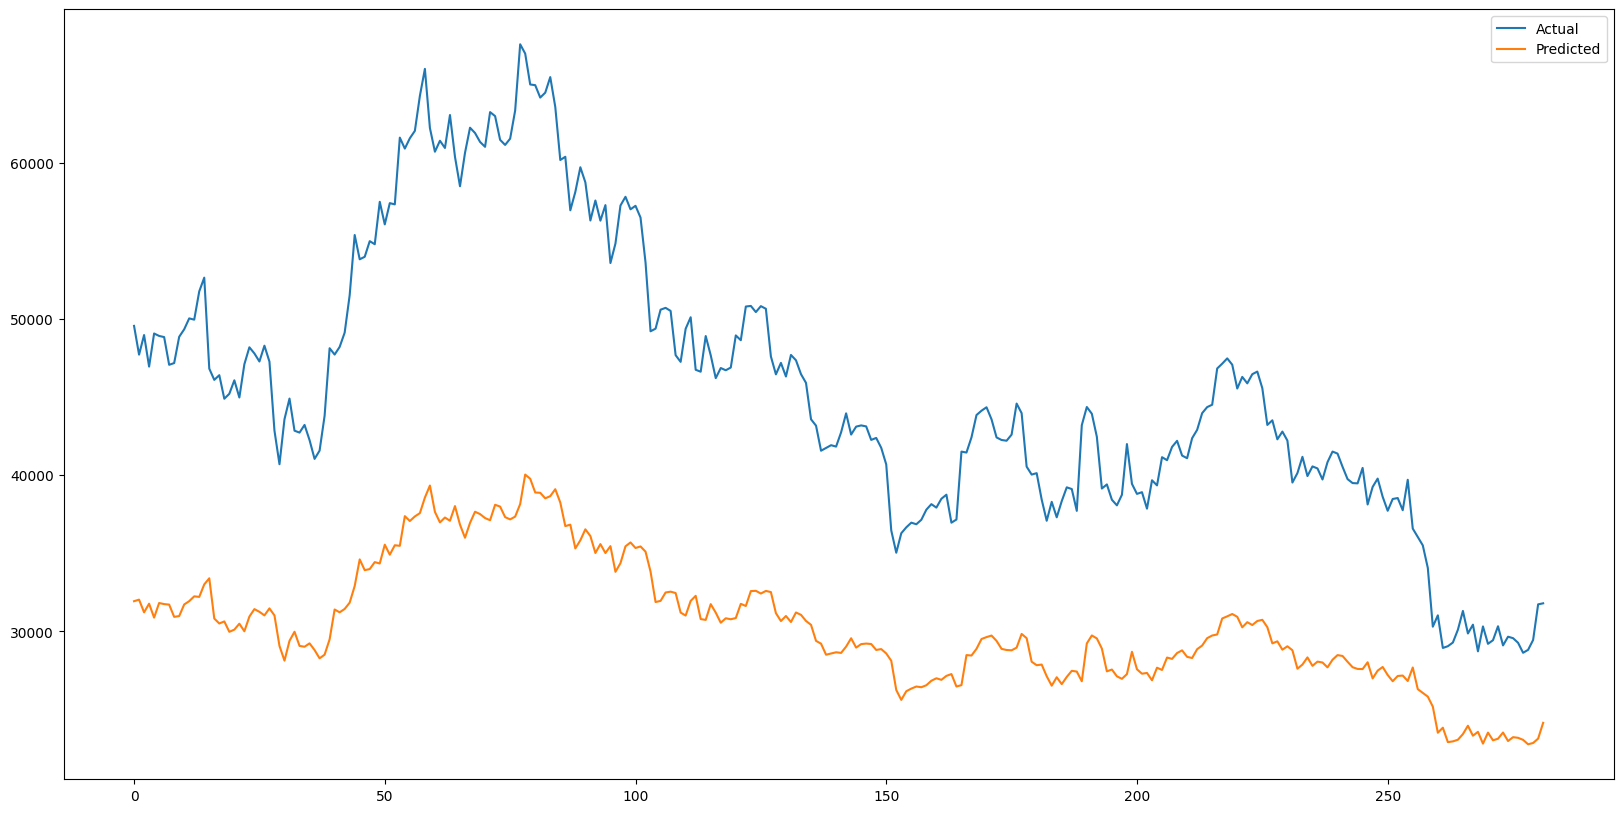

In [18]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [19]:
# Calculating the RMSE and MAE
rmse = np.sqrt(np.mean((test_results_unscaled['Actual'] - test_results_unscaled['Predicted'])**2))
mae = np.mean(np.abs(test_results_unscaled['Actual'] - test_results_unscaled['Predicted']))
rmse, mae

(16205.216567547224, 15356.628830064274)

# 3 Day Look Back Window

In [20]:
x_3.shape, y_3.shape

((2811, 3, 1), (2811, 1))

In [21]:
X_3_train, y_3_train = x_3[:int(0.8*len(x_3))], y_3[:int(0.8*len(x_3))]
X_3_val, y_3_val = x_3[int(0.8*len(x_3)):int(0.9*len(x_3))], y_3[int(0.8*len(x_3)):int(0.9*len(x_3))]
X_3_test, y_3_test = x_3[int(0.9*len(x_3)):], y_3[int(0.9*len(x_3)):]
X_3_train.shape, y_3_train.shape, X_3_val.shape, y_3_val.shape, X_3_test.shape, y_3_test.shape

((2248, 3, 1), (2248, 1), (281, 3, 1), (281, 1), (282, 3, 1), (282, 1))

In [22]:
model_3 = Sequential()
model_3.add(InputLayer(input_shape = (3, 1)))
model_3.add(GRU(64))
model_3.add(Dense(8, activation = 'relu'))
model_3.add(Dense(1, activation = 'linear'))

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
cp3 = ModelCheckpoint('models/gru_3.h5', save_best_only = True)
model_3.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [24]:
model_3.fit(X_3_train, y_3_train, epochs = 200, validation_data = (X_3_val, y_3_val), callbacks = [cp3])

Epoch 1/200
71/71 [==============================] - 1s 4ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - mean_absolute_error: 0.0532 - val_loss: 0.2556 - val_root_mean_squared_error: 0.5055 - val_mean_absolute_error: 0.4774
Epoch 2/200
71/71 [==============================] - 0s 2ms/step - loss: 0.0027 - root_mean_squared_error: 0.0518 - mean_absolute_error: 0.0456 - val_loss: 0.2019 - val_root_mean_squared_error: 0.4494 - val_mean_absolute_error: 0.4227
Epoch 3/200
34/71 [=============>................] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0423

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 0s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464 - mean_absolute_error: 0.0413 - val_loss: 0.1654 - val_root_mean_squared_error: 0.4067 - val_mean_absolute_error: 0.3821
Epoch 4/200
71/71 [==============================] - 0s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - mean_absolute_error: 0.0362 - val_loss: 0.1269 - val_root_mean_squared_error: 0.3562 - val_mean_absolute_error: 0.3341
Epoch 5/200
71/71 [==============================] - 0s 1ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - mean_absolute_error: 0.0306 - val_loss: 0.0910 - val_root_mean_squared_error: 0.3016 - val_mean_absolute_error: 0.2824
Epoch 6/200
71/71 [==============================] - 0s 1ms/step - loss: 7.6522e-04 - root_mean_squared_error: 0.0277 - mean_absolute_error: 0.0243 - val_loss: 0.0588 - val_root_mean_squared_error: 0.2426 - val_mean_absolute_error: 0.2264
Epoch 7/200
71/71 [==============================] - 0s 1ms/step - l

In [25]:
model_3 = load_model('models/gru_3.h5')

In [26]:
test_3_predictions = model_3.predict(X_3_test)
test_3_results = pd.DataFrame({'Actual': y_3_test.flatten(), 'Predicted': test_3_predictions.flatten()})
test_3_results

9/9 [==============================] - 0s 612us/step


,Actual,Predicted
0,0.732586,0.663542
1,0.705281,0.664119
2,0.723900,0.662081
3,0.693946,0.657377
4,0.725352,0.648609
...,...,...
277,0.422170,0.406865
278,0.424949,0.403004
279,0.434314,0.398926
280,0.468154,0.398604


In [27]:
# Creating a dataframe with the actual and predicted values without the scaling
test_3_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_3_test).flatten(), 'Predicted': scaler.inverse_transform(test_3_predictions).flatten()})

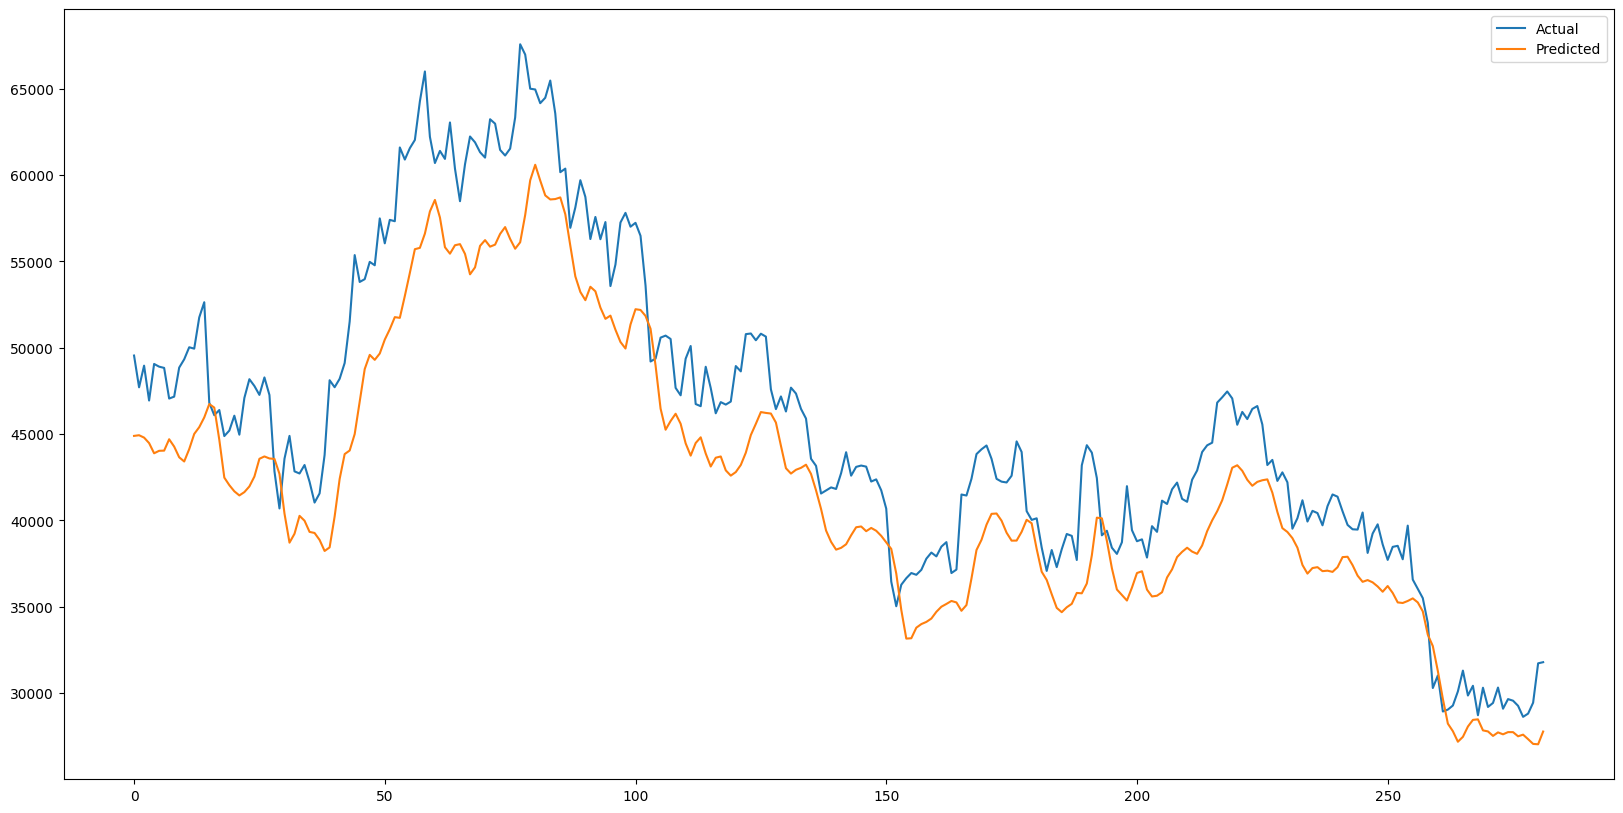

In [28]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_3_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_3_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [29]:
# Calculating the RMSE and MAE
rmse_3 = np.sqrt(np.mean((test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted'])**2))
mae_3 = np.mean(np.abs(test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted']))
rmse_3, mae_3

(4350.797989264903, 3823.112934951241)

# 7 Day Look Back Window

In [30]:
x_7.shape, y_7.shape

((2807, 7, 1), (2807, 1))

In [31]:
X_7_train, y_7_train = x_7[:int(0.8*len(x_7))], y_7[:int(0.8*len(x_7))]
X_7_val, y_7_val = x_7[int(0.8*len(x_7)):int(0.9*len(x_7))], y_7[int(0.8*len(x_7)):int(0.9*len(x_7))]
X_7_test, y_7_test = x_7[int(0.9*len(x_7)):], y_7[int(0.9*len(x_7)):]
X_7_train.shape, y_7_train.shape, X_7_val.shape, y_7_val.shape, X_7_test.shape, y_7_test.shape

((2245, 7, 1), (2245, 1), (281, 7, 1), (281, 1), (281, 7, 1), (281, 1))

In [32]:
model_7 = Sequential()
model_7.add(InputLayer(input_shape = (7, 1)))
model_7.add(GRU(64))
model_7.add(Dense(8, activation = 'relu'))
model_7.add(Dense(1, activation = 'linear'))

model_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
cp7 = ModelCheckpoint('models/gru_7.h5', save_best_only = True)
model_7.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [34]:
model_7.fit(X_7_train, y_7_train, epochs = 200, validation_data = (X_7_val, y_7_val), callbacks = [cp7])

Epoch 1/200
71/71 [==============================] - 1s 5ms/step - loss: 0.0061 - root_mean_squared_error: 0.0778 - mean_absolute_error: 0.0570 - val_loss: 0.3133 - val_root_mean_squared_error: 0.5598 - val_mean_absolute_error: 0.5300
Epoch 2/200
71/71 [==============================] - 0s 2ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - mean_absolute_error: 0.0459 - val_loss: 0.2319 - val_root_mean_squared_error: 0.4816 - val_mean_absolute_error: 0.4529
Epoch 3/200
 1/71 [..............................] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0482 - mean_absolute_error: 0.0403

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 0s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - mean_absolute_error: 0.0376 - val_loss: 0.1755 - val_root_mean_squared_error: 0.4190 - val_mean_absolute_error: 0.3921
Epoch 4/200
71/71 [==============================] - 0s 4ms/step - loss: 9.9140e-04 - root_mean_squared_error: 0.0315 - mean_absolute_error: 0.0272 - val_loss: 0.1211 - val_root_mean_squared_error: 0.3479 - val_mean_absolute_error: 0.3237
Epoch 5/200
71/71 [==============================] - 0s 3ms/step - loss: 3.6156e-04 - root_mean_squared_error: 0.0190 - mean_absolute_error: 0.0153 - val_loss: 0.0714 - val_root_mean_squared_error: 0.2673 - val_mean_absolute_error: 0.2460
Epoch 6/200
71/71 [==============================] - 0s 3ms/step - loss: 9.5458e-05 - root_mean_squared_error: 0.0098 - mean_absolute_error: 0.0063 - val_loss: 0.0460 - val_root_mean_squared_error: 0.2145 - val_mean_absolute_error: 0.1950
Epoch 7/200
71/71 [==============================] - 0s 2ms/

In [35]:
model_7 = load_model('models/gru_7.h5')

In [36]:
test_7_predictions = model_7.predict(X_7_test)
test_7_results = pd.DataFrame({'Actual': y_7_test.flatten(), 'Predicted': test_7_predictions.flatten()})
test_7_results

9/9 [==============================] - 0s 805us/step


,Actual,Predicted
0,0.705281,0.574627
1,0.723900,0.570289
2,0.693946,0.571464
3,0.725352,0.565087
4,0.723033,0.568141
...,...,...
276,0.422170,0.385509
277,0.424949,0.382496
278,0.434314,0.380986
279,0.468154,0.382286


In [37]:
# Creating a dataframe with the actual and predicted values without the scaling
test_7_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_7_test).flatten(), 'Predicted': scaler.inverse_transform(test_7_predictions).flatten()})

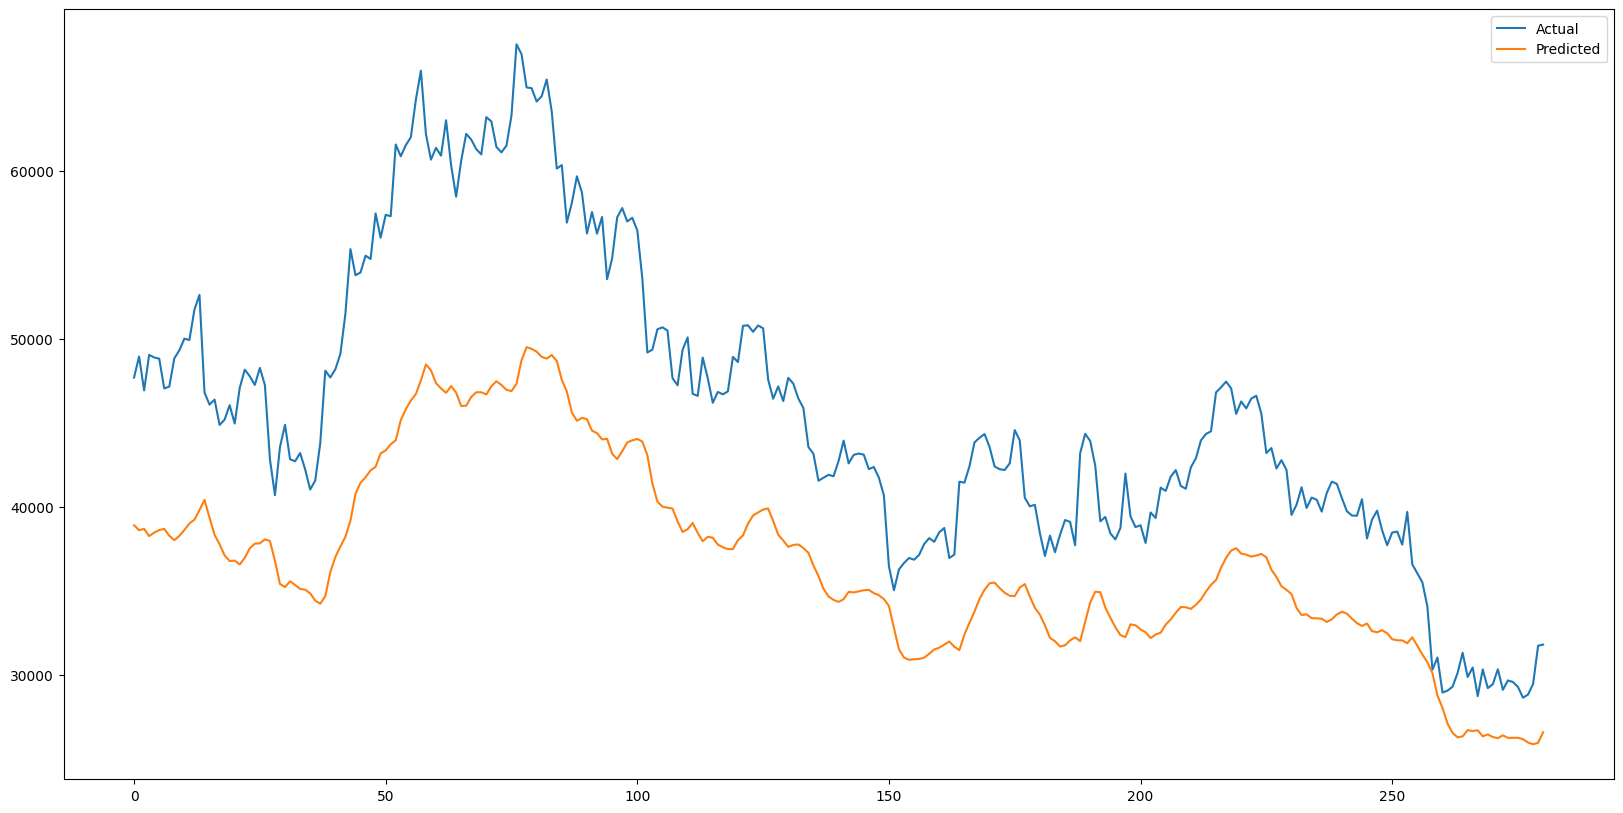

In [38]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_7_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_7_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [39]:
rmse_7 = np.sqrt(np.mean((test_7_results_unscaled['Actual'] - test_7_results_unscaled['Predicted'])**2))
mae_7 = np.mean(np.abs(test_7_results_unscaled['Actual'] - test_7_results_unscaled['Predicted']))
rmse_7, mae_7

(9626.852269491761, 8896.85526718194)

# 15 Day Look Back Window

In [40]:
x_15.shape, y_15.shape

((2799, 15, 1), (2799, 1))

In [41]:
X_15_train, y_15_train = x_15[:int(0.8*len(x_15))], y_15[:int(0.8*len(x_15))]
X_15_val, y_15_val = x_15[int(0.8*len(x_15)):int(0.9*len(x_15))], y_15[int(0.8*len(x_15)):int(0.9*len(x_15))]
X_15_test, y_15_test = x_15[int(0.9*len(x_15)):], y_15[int(0.9*len(x_15)):]
X_15_train.shape, y_15_train.shape, X_15_val.shape, y_15_val.shape, X_15_test.shape, y_15_test.shape

((2239, 15, 1), (2239, 1), (280, 15, 1), (280, 1), (280, 15, 1), (280, 1))

In [42]:
model_15 = Sequential()
model_15.add(InputLayer(input_shape = (15, 1)))
model_15.add(GRU(64))
model_15.add(Dense(8, activation = 'relu'))
model_15.add(Dense(1, activation = 'linear'))

model_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                12864     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
cp15 = ModelCheckpoint('models/gru_15.h5', save_best_only = True)
model_15.compile(optimizer = Adam(learning_rate = 0.001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [44]:
model_15.fit(X_15_train, y_15_train, epochs = 200, validation_data = (X_15_val, y_15_val), callbacks = [cp15])

Epoch 1/200
70/70 [==============================] - 1s 6ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0216 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2035 - val_mean_absolute_error: 0.1822
Epoch 2/200
51/70 [====================>.........] - ETA: 0s - loss: 4.6574e-05 - root_mean_squared_error: 0.0068 - mean_absolute_error: 0.0039

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 0s 3ms/step - loss: 4.3301e-05 - root_mean_squared_error: 0.0066 - mean_absolute_error: 0.0037 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1844 - val_mean_absolute_error: 0.1633
Epoch 3/200
70/70 [==============================] - 0s 4ms/step - loss: 4.5711e-05 - root_mean_squared_error: 0.0068 - mean_absolute_error: 0.0042 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705 - val_mean_absolute_error: 0.1494
Epoch 4/200
70/70 [==============================] - 0s 4ms/step - loss: 4.2563e-05 - root_mean_squared_error: 0.0065 - mean_absolute_error: 0.0040 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1819 - val_mean_absolute_error: 0.1609
Epoch 5/200
70/70 [==============================] - 0s 4ms/step - loss: 4.0516e-05 - root_mean_squared_error: 0.0064 - mean_absolute_error: 0.0040 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1786 - val_mean_absolute_error: 0.1575
Epoch 6/200
70/70 [==============================] - 0s 

In [45]:
model_15 = load_model('models/gru_15.h5')

In [46]:
test_15_predictions = model_15.predict(X_15_test)
test_15_results = pd.DataFrame({'Actual': y_15_test.flatten(), 'Predicted': test_15_predictions.flatten()})
test_15_results

9/9 [==============================] - 0s 1ms/step


,Actual,Predicted
0,0.723900,0.699656
1,0.693946,0.724607
2,0.725352,0.688245
3,0.723033,0.727817
4,0.721957,0.719846
...,...,...
275,0.422170,0.435211
276,0.424949,0.425385
277,0.434314,0.429294
278,0.468154,0.439072


In [47]:
# Creating a dataframe with the actual and predicted values without the scaling
test_15_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_15_test).flatten(), 'Predicted': scaler.inverse_transform(test_15_predictions).flatten()})

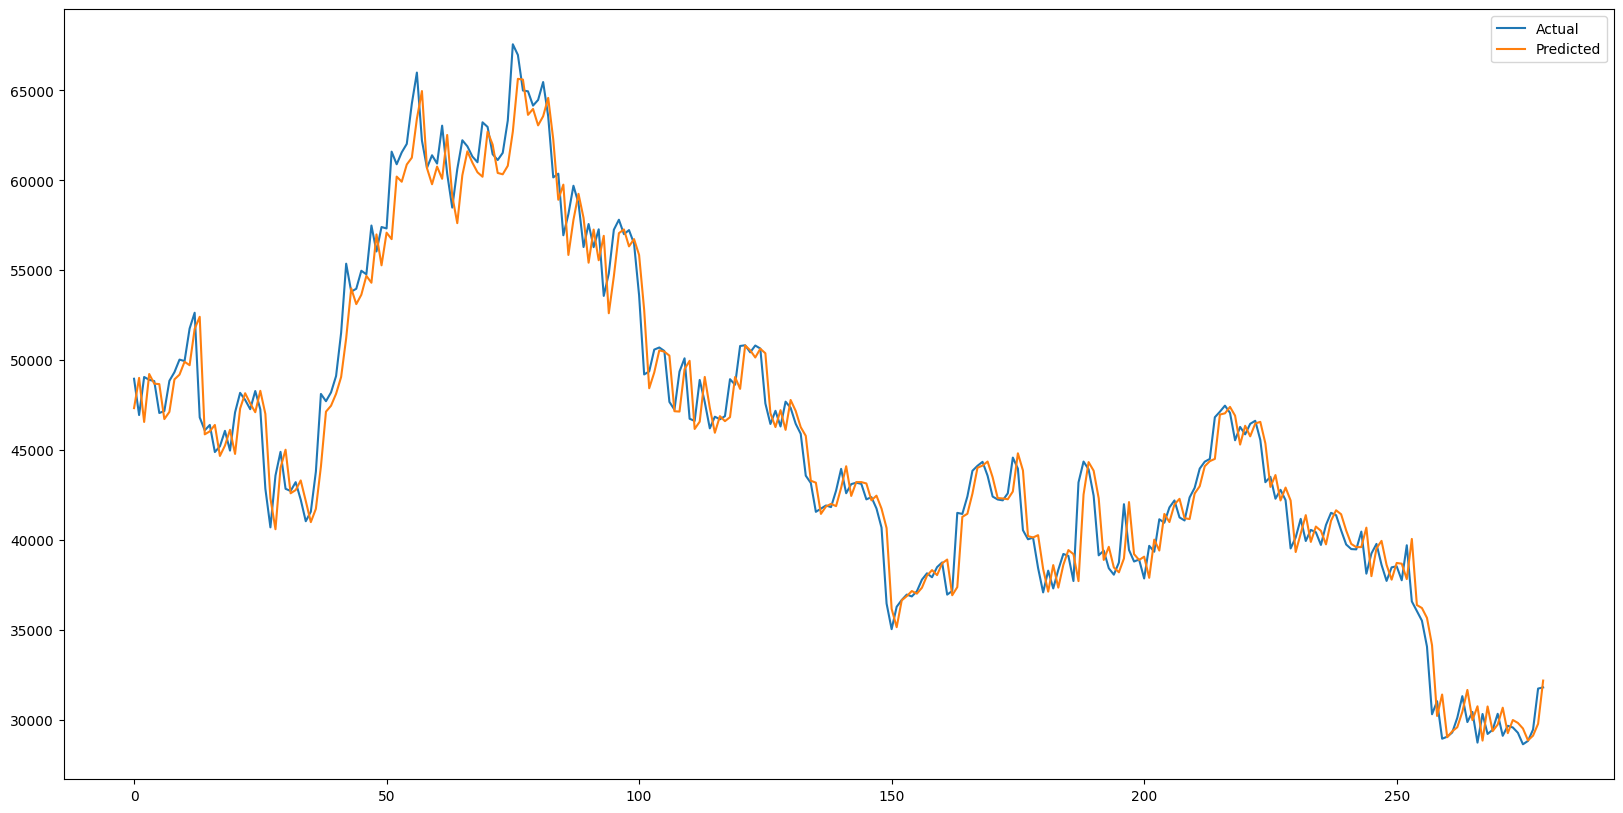

In [48]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_15_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_15_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [49]:
rmse_15 = np.sqrt(np.mean((test_15_results_unscaled['Actual'] - test_15_results_unscaled['Predicted'])**2))
mae_15 = np.mean(np.abs(test_15_results_unscaled['Actual'] - test_15_results_unscaled['Predicted']))
rmse_15, mae_15

(1594.174817074382, 1179.3064383370536)

# 30 Day Look Back Window

In [50]:
x_30.shape, y_30.shape

((2784, 30, 1), (2784, 1))

In [51]:
X_30_train, y_30_train = x_30[:int(0.8*len(x_30))], y_30[:int(0.8*len(x_30))]
X_30_val, y_30_val = x_30[int(0.8*len(x_30)):int(0.9*len(x_30))], y_30[int(0.8*len(x_30)):int(0.9*len(x_30))]
X_30_test, y_30_test = x_30[int(0.9*len(x_30)):], y_30[int(0.9*len(x_30)):]
X_30_train.shape, y_30_train.shape, X_30_val.shape, y_30_val.shape, X_30_test.shape, y_30_test.shape

((2227, 30, 1), (2227, 1), (278, 30, 1), (278, 1), (279, 30, 1), (279, 1))

In [52]:
model_30 = Sequential()
model_30.add(InputLayer(input_shape = (30, 1)))
model_30.add(GRU(64))
model_30.add(Dense(8, activation = 'relu'))
model_30.add(Dense(1, activation = 'linear'))

model_30.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                12864     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
cp30 = ModelCheckpoint('models/gru_30.h5', save_best_only = True)
model_30.compile(optimizer = Adam(learning_rate = 0.001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [54]:
model_30.fit(X_30_train, y_30_train, epochs = 200, validation_data = (X_30_val, y_30_val), callbacks = [cp30])

Epoch 1/200
70/70 [==============================] - 1s 8ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 - mean_absolute_error: 0.0311 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1712 - val_mean_absolute_error: 0.1520
Epoch 2/200
29/70 [===========>..................] - ETA: 0s - loss: 1.1068e-04 - root_mean_squared_error: 0.0105 - mean_absolute_error: 0.0069

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 0s 6ms/step - loss: 8.7326e-05 - root_mean_squared_error: 0.0093 - mean_absolute_error: 0.0060 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739 - val_mean_absolute_error: 0.0578
Epoch 3/200
70/70 [==============================] - 0s 7ms/step - loss: 6.7713e-05 - root_mean_squared_error: 0.0082 - mean_absolute_error: 0.0050 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151 - val_mean_absolute_error: 0.1012
Epoch 4/200
70/70 [==============================] - 1s 10ms/step - loss: 4.7820e-05 - root_mean_squared_error: 0.0069 - mean_absolute_error: 0.0039 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197 - val_mean_absolute_error: 0.1060
Epoch 5/200
70/70 [==============================] - 0s 6ms/step - loss: 3.9400e-05 - root_mean_squared_error: 0.0063 - mean_absolute_error: 0.0036 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.0492
Epoch 6/200
70/70 [==============================] - 0s

In [55]:
model_30 = load_model('models/gru_30.h5')

In [56]:
test_30_predictions = model_30.predict(X_30_test)
test_30_results = pd.DataFrame({'Actual': y_30_test.flatten(), 'Predicted': test_30_predictions.flatten()})
test_30_results

9/9 [==============================] - 0s 2ms/step


,Actual,Predicted
0,0.693946,0.717227
1,0.725352,0.680172
2,0.723033,0.720396
3,0.721957,0.712128
4,0.695619,0.710431
...,...,...
274,0.422170,0.435326
275,0.424949,0.425710
276,0.434314,0.429953
277,0.468154,0.439751


In [57]:
# Creating a dataframe with the actual and predicted values without the scaling
test_30_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_30_test).flatten(), 'Predicted': scaler.inverse_transform(test_30_predictions).flatten()})

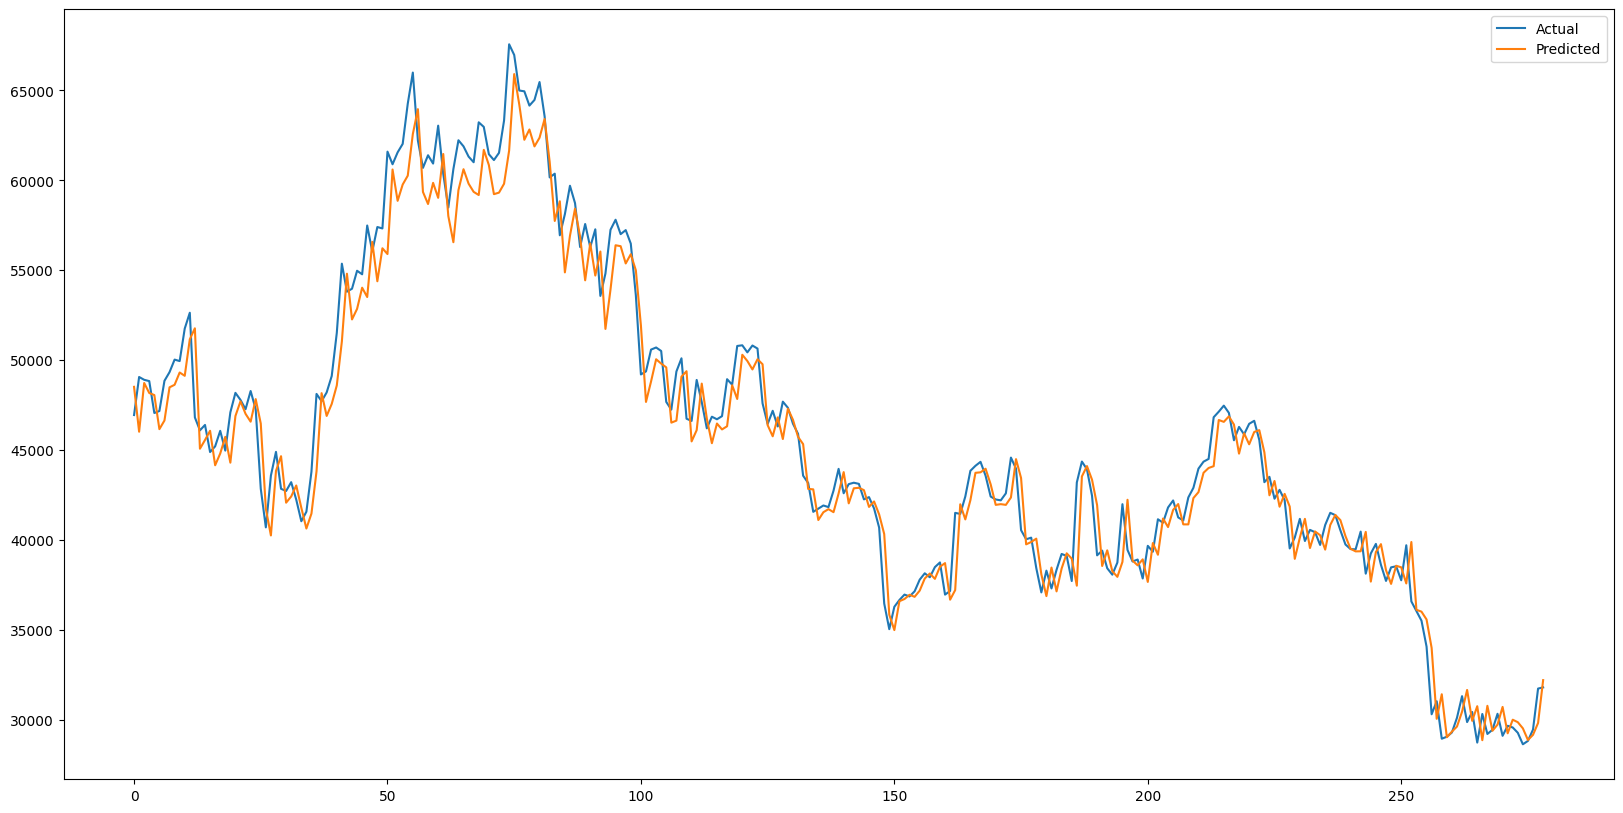

In [58]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_30_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_30_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [59]:
rmse_30 = np.sqrt(np.mean((test_30_results_unscaled['Actual'] - test_30_results_unscaled['Predicted'])**2))
mae_30 = np.mean(np.abs(test_30_results_unscaled['Actual'] - test_30_results_unscaled['Predicted']))
rmse_30, mae_30

(1756.247269694426, 1332.8155661962367)

# 60 Day Look Back Window

In [60]:
x_60.shape, y_60.shape

((2754, 60, 1), (2754, 1))

In [61]:
X_60_train, y_60_train = x_60[:int(0.8*len(x_60))], y_60[:int(0.8*len(x_60))]
X_60_val, y_60_val = x_60[int(0.8*len(x_60)):int(0.9*len(x_60))], y_60[int(0.8*len(x_60)):int(0.9*len(x_60))]
X_60_test, y_60_test = x_60[int(0.9*len(x_60)):], y_60[int(0.9*len(x_60)):]
X_60_train.shape, y_60_train.shape, X_60_val.shape, y_60_val.shape, X_60_test.shape, y_60_test.shape

((2203, 60, 1), (2203, 1), (275, 60, 1), (275, 1), (276, 60, 1), (276, 1))

In [62]:
model_60 = Sequential()
model_60.add(InputLayer(input_shape = (60, 1)))
model_60.add(GRU(64))
model_60.add(Dense(8, activation = 'relu'))
model_60.add(Dense(1, activation = 'linear'))

model_60.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                12864     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
cp60 = ModelCheckpoint('models/gru_60.h5', save_best_only = True)
model_60.compile(optimizer = Adam(learning_rate = 0.001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [64]:
model_60.fit(X_60_train, y_60_train, epochs = 200, validation_data = (X_60_val, y_60_val), callbacks = [cp60])

Epoch 1/200
69/69 [==============================] - 2s 13ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - mean_absolute_error: 0.0277 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990 - val_mean_absolute_error: 0.0844
Epoch 2/200
17/69 [======>.......................] - ETA: 0s - loss: 5.6386e-05 - root_mean_squared_error: 0.0075 - mean_absolute_error: 0.0046

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 1s 12ms/step - loss: 5.2975e-05 - root_mean_squared_error: 0.0073 - mean_absolute_error: 0.0044 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0911 - val_mean_absolute_error: 0.0765
Epoch 3/200
69/69 [==============================] - 1s 12ms/step - loss: 4.5513e-05 - root_mean_squared_error: 0.0067 - mean_absolute_error: 0.0039 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896 - val_mean_absolute_error: 0.0750
Epoch 4/200
69/69 [==============================] - 1s 11ms/step - loss: 4.4216e-05 - root_mean_squared_error: 0.0066 - mean_absolute_error: 0.0040 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0718
Epoch 5/200
69/69 [==============================] - 1s 10ms/step - loss: 3.8764e-05 - root_mean_squared_error: 0.0062 - mean_absolute_error: 0.0036 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871 - val_mean_absolute_error: 0.0729
Epoch 6/200
69/69 [==============================] -

In [65]:
model_60 = load_model('models/gru_60.h5')

In [66]:
test_60_predictions = model_60.predict(X_60_test)
test_60_results = pd.DataFrame({'Actual': y_60_test.flatten(), 'Predicted': test_60_predictions.flatten()})

9/9 [==============================] - 0s 3ms/step


In [67]:
# Creating a dataframe with the actual and predicted values without the scaling
test_60_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_60_test).flatten(), 'Predicted': scaler.inverse_transform(test_60_predictions).flatten()})
test_60_results_unscaled

,Actual,Predicted
0,48829.832031,48278.902344
1,47054.984375,48318.761719
2,47166.687500,46304.031250
3,48847.027344,46774.203125
4,49327.722656,48585.558594
...,...,...
271,28627.574219,29338.375000
272,28814.900391,28670.367188
273,29445.957031,28950.933594
274,31726.390625,29606.455078


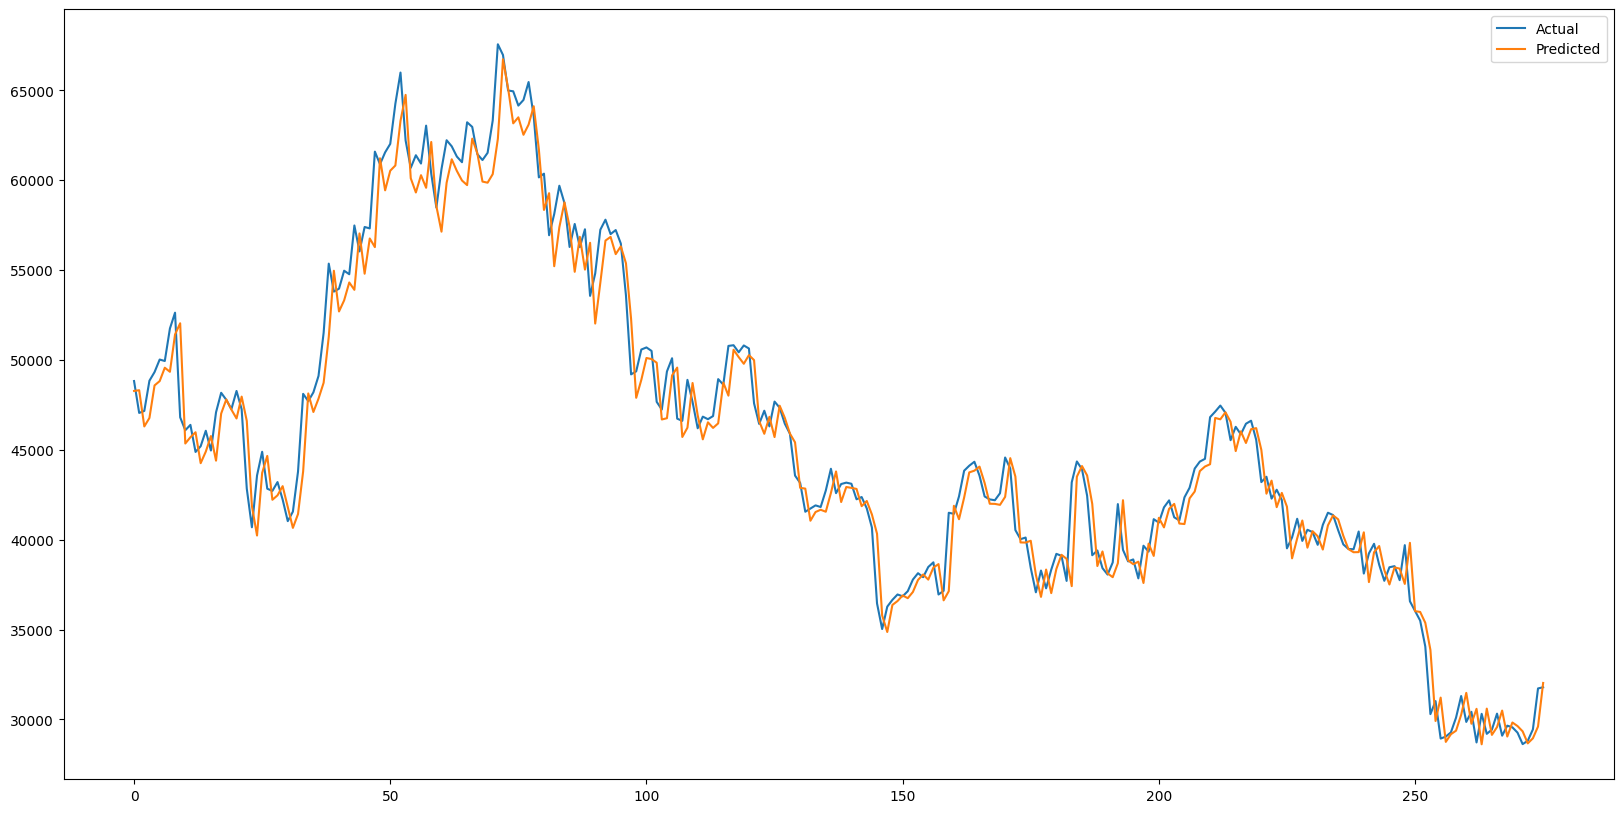

In [68]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_60_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_60_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [69]:
rmse_60 = np.sqrt(np.mean((test_60_results_unscaled['Actual'] - test_60_results_unscaled['Predicted'])**2))
mae_60 = np.mean(np.abs(test_60_results_unscaled['Actual'] - test_60_results_unscaled['Predicted']))
rmse_60, mae_60

(1651.4197356795664, 1243.8716527966485)

# Comparing the models 

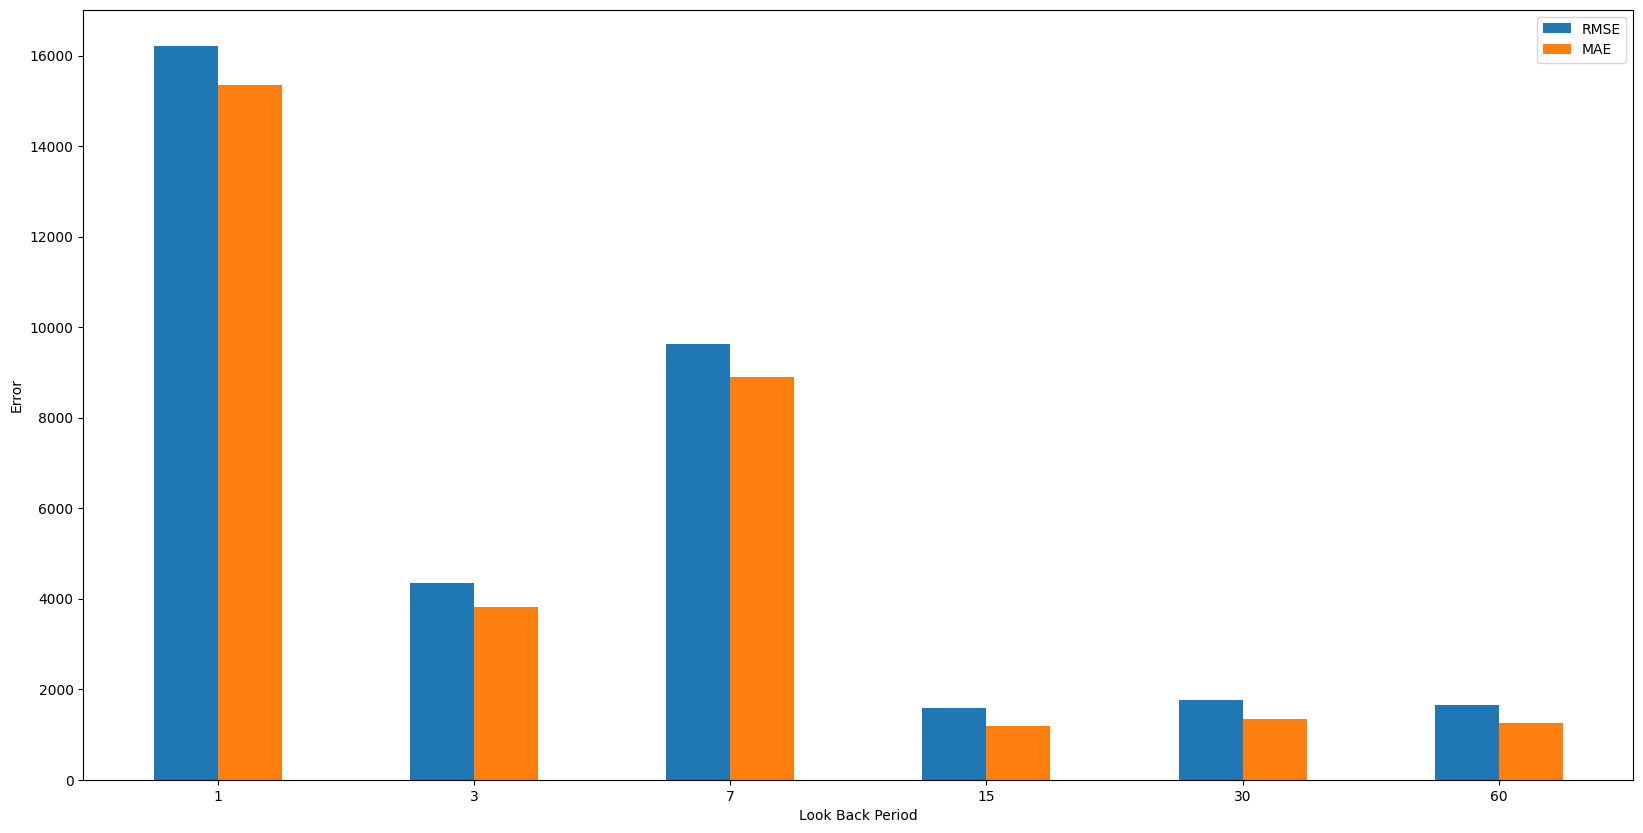

In [70]:
# Plotting in a bar chart, the RMSE and MAE for each look back period. The two metrics are plotted side by side for each look back period
plt.figure(figsize = (20, 10))
plt.bar(np.arange(6), [rmse, rmse_3, rmse_7, rmse_15, rmse_30, rmse_60], width = 0.25, label = 'RMSE')
plt.bar(np.arange(6) + 0.25, [mae, mae_3, mae_7, mae_15, mae_30, mae_60], width = 0.25, label = 'MAE')
plt.xticks(np.arange(6) + 0.125, ['1', '3', '7', '15', '30', '60'])
plt.xlabel('Look Back Period')
plt.ylabel('Error')
plt.legend()